# 2 Layer Neural Network

## Imports

In [1]:
import os
import pandas as pd

## Import data and create .csv

In [2]:
# Directory to MRI Images
base_dir = '/Users/venkatasaikrishna.gudladona/src/machinelearning/229FinalProject/AugmentedAlzheimerDataset'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

if not os.path.exists('new_dataset.csv'):
    data = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            data.append([image_path, label])

    df = pd.DataFrame(data, columns=['path', 'label'])
    df.to_csv('new_dataset.csv', index=False)

## Data Loading and Pre-Processing

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224 X 224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

# Load the entire dataset
dataset = CustomDataset(csv_file='new_dataset.csv', transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [4]:
print(f'Training Samples: {len(train_dataset)}')
print(f'Validation Samples: {len(val_dataset)}')
print(f'Test Samples: {len(test_dataset)}')

Training Samples: 23788
Validation Samples: 5097
Test Samples: 5099


In [5]:
print(train_dataset)

In [6]:
import matplotlib.pyplot as plt
#plt.plot(train_dataset[0][0])
#plt.show()

## Pytorch Logistic Regression Model

In [7]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet18, ResNet18_Weights

class AttentionBlock(nn.Module):
    def __init__(self, in_channels, feature_size=1):
        super(AttentionBlock, self).__init__()
        self.attention = nn.MultiheadAttention(in_channels, num_heads=1)
        self.norm = nn.LayerNorm(in_channels)
    
    def forward(self, x):
        #print("Attention Block Input Shape (before reshape):", x.shape)
        # Original shape: [batch, channels, height, width]
        b, c, h, w = x.size()
        x = x.view(b, c, h * w).transpose(1, 2)  # Reshape to [batch, height*width, channels]
        #print("Attention Block Reshaped Input Shape:", x.shape)
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        x = self.norm(x)
        x = x.transpose(1, 2).view(b, c, h, w)  # Reshape back to [batch, channels, height, width]
        #print("Attention Block Output Shape (after reshape):", x.shape)
        return x


class ResNetWithAttention(nn.Module):
    def __init__(self):
        super(ResNetWithAttention, self).__init__()
        # Load the ResNet18 model without the final fully connected layer
        self.resnet = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        # Add attention block
        self.attention = AttentionBlock(512, feature_size=1)
        # Add a new fully connected layer for classification
        self.fc = nn.Linear(512, 4)

    def forward(self, x):
        # Extract features from ResNet layers
        x = self.resnet(x)
        #print("ResNet Output Shape:", x.shape)
        # Apply attention block
        x = self.attention(x)
        # Adaptive average pooling to reduce the spatial dimensions
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)  # Flatten the features
        #print("Before FC Layer Shape:", x.shape)
        # Classification layer
        x = self.fc(x)
        return x

# Create an instance of the modified ResNet-18 with attention
model = ResNetWithAttention()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNetWithAttention(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

## Training Loop

In [8]:
learning_rate = 0.01
num_epochs = 20
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSProp(model.parameters(), lr=learning_rate)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
print('current lr=', optimizer.param_groups[0]['lr'])

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    i = 0
    for inputs, labels in train_loader:
        i = i + 1
        print("Training continues..", total_loss, "current i = ", i)    
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    #lr decay
    lr_scheduler.step()

    print(f"Iteration {epoch} lr = {optimizer.param_groups[0]['lr']} - Loss = {total_loss / len(train_loader)}")

current lr= 0.01
Training continues.. 0.0 current i =  1
Training continues.. 1.4363703727722168 current i =  2
Training continues.. 2.8667237758636475 current i =  3
Training continues.. 4.225078225135803 current i =  4
Training continues.. 5.567815661430359 current i =  5
Training continues.. 6.886473774909973 current i =  6
Training continues.. 8.254480481147766 current i =  7
Training continues.. 9.593059062957764 current i =  8
Training continues.. 10.899472713470459 current i =  9
Training continues.. 12.25476849079132 current i =  10
Training continues.. 13.621710062026978 current i =  11
Training continues.. 14.916264653205872 current i =  12
Training continues.. 16.16681969165802 current i =  13
Training continues.. 17.502240657806396 current i =  14
Training continues.. 18.845616936683655 current i =  15
Training continues.. 20.14723241329193 current i =  16
Training continues.. 21.415668487548828 current i =  17
Training continues.. 22.62814176082611 current i =  18
Training

Training continues.. 137.32582199573517 current i =  149
Training continues.. 138.01569992303848 current i =  150
Training continues.. 138.79477643966675 current i =  151
Training continues.. 139.61146491765976 current i =  152
Training continues.. 140.36272025108337 current i =  153
Training continues.. 140.9920455813408 current i =  154
Training continues.. 141.71684032678604 current i =  155
Training continues.. 142.3985960483551 current i =  156
Training continues.. 143.08601474761963 current i =  157
Training continues.. 143.79245793819427 current i =  158
Training continues.. 144.50051009655 current i =  159
Training continues.. 145.23537135124207 current i =  160
Training continues.. 145.83169263601303 current i =  161
Training continues.. 146.4792339205742 current i =  162
Training continues.. 147.18631315231323 current i =  163
Training continues.. 147.93144911527634 current i =  164
Training continues.. 148.62230956554413 current i =  165
Training continues.. 149.405805051326

Training continues.. 227.16552859544754 current i =  294
Training continues.. 227.68036526441574 current i =  295
Training continues.. 228.21167588233948 current i =  296
Training continues.. 228.69322988390923 current i =  297
Training continues.. 229.27883276343346 current i =  298
Training continues.. 229.7967856824398 current i =  299
Training continues.. 230.30425634980202 current i =  300
Training continues.. 230.6689908206463 current i =  301
Training continues.. 231.0939772427082 current i =  302
Training continues.. 231.55224213004112 current i =  303
Training continues.. 232.22619304060936 current i =  304
Training continues.. 232.8516773879528 current i =  305
Training continues.. 233.44810751080513 current i =  306
Training continues.. 234.0207363665104 current i =  307
Training continues.. 234.62709012627602 current i =  308
Training continues.. 235.1090043783188 current i =  309
Training continues.. 235.61696249246597 current i =  310
Training continues.. 236.063738584518

Training continues.. 24.503448575735092 current i =  68
Training continues.. 24.900197714567184 current i =  69
Training continues.. 25.239394396543503 current i =  70
Training continues.. 25.589203238487244 current i =  71
Training continues.. 25.96171149611473 current i =  72
Training continues.. 26.258860528469086 current i =  73
Training continues.. 26.463514894247055 current i =  74
Training continues.. 26.751018792390823 current i =  75
Training continues.. 27.01417851448059 current i =  76
Training continues.. 27.379165142774582 current i =  77
Training continues.. 27.620203465223312 current i =  78
Training continues.. 27.812047258019447 current i =  79
Training continues.. 28.115313693881035 current i =  80
Training continues.. 28.427379354834557 current i =  81
Training continues.. 28.871450886130333 current i =  82
Training continues.. 29.19067431986332 current i =  83
Training continues.. 29.49695275723934 current i =  84
Training continues.. 29.863919869065285 current i = 

Training continues.. 68.21365776658058 current i =  215
Training continues.. 68.43427011370659 current i =  216
Training continues.. 68.69123440980911 current i =  217
Training continues.. 69.0547641813755 current i =  218
Training continues.. 69.30204236507416 current i =  219
Training continues.. 69.46490758657455 current i =  220
Training continues.. 69.81910648941994 current i =  221
Training continues.. 70.06786650419235 current i =  222
Training continues.. 70.4071492254734 current i =  223
Training continues.. 70.60358296334743 current i =  224
Training continues.. 70.78638762235641 current i =  225
Training continues.. 71.00337593257427 current i =  226
Training continues.. 71.21993274986744 current i =  227
Training continues.. 71.67253662645817 current i =  228
Training continues.. 71.99375353753567 current i =  229
Training continues.. 72.17433132231236 current i =  230
Training continues.. 72.3999342918396 current i =  231
Training continues.. 72.58090916275978 current i = 

Training continues.. 101.33658450096846 current i =  362
Training continues.. 101.43644534796476 current i =  363
Training continues.. 101.66766097396612 current i =  364
Training continues.. 101.82056557387114 current i =  365
Training continues.. 101.98389215022326 current i =  366
Training continues.. 102.33351523429155 current i =  367
Training continues.. 102.54489663988352 current i =  368
Training continues.. 102.71369213610888 current i =  369
Training continues.. 102.85551475733519 current i =  370
Training continues.. 102.99467257410288 current i =  371
Training continues.. 103.16249091178179 current i =  372
Iteration 1 lr = 0.01 - Loss = 0.2778417285211304
Training continues.. 0.0 current i =  1
Training continues.. 0.11972076445817947 current i =  2
Training continues.. 0.2210269197821617 current i =  3
Training continues.. 0.3049270659685135 current i =  4
Training continues.. 0.4186139404773712 current i =  5
Training continues.. 0.5281234979629517 current i =  6
Trainin

Training continues.. 14.167205518111587 current i =  137
Training continues.. 14.260231940075755 current i =  138
Training continues.. 14.411803198978305 current i =  139
Training continues.. 14.444147365167737 current i =  140
Training continues.. 14.525304609909654 current i =  141
Training continues.. 14.602494331076741 current i =  142
Training continues.. 14.6950280983001 current i =  143
Training continues.. 14.790141487494111 current i =  144
Training continues.. 14.829910887405276 current i =  145
Training continues.. 14.88362473808229 current i =  146
Training continues.. 15.025125732645392 current i =  147
Training continues.. 15.114986894652247 current i =  148
Training continues.. 15.19261003099382 current i =  149
Training continues.. 15.353393187746406 current i =  150
Training continues.. 15.45479472540319 current i =  151
Training continues.. 15.513709211722016 current i =  152
Training continues.. 15.620753252878785 current i =  153
Training continues.. 15.710306013002

Training continues.. 26.19161200337112 current i =  283
Training continues.. 26.220655024051666 current i =  284
Training continues.. 26.26898331195116 current i =  285
Training continues.. 26.395864956080914 current i =  286
Training continues.. 26.453470427542925 current i =  287
Training continues.. 26.55884951725602 current i =  288
Training continues.. 26.616573080420494 current i =  289
Training continues.. 26.672069489955902 current i =  290
Training continues.. 26.762026198208332 current i =  291
Training continues.. 26.821338143199682 current i =  292
Training continues.. 26.86675338074565 current i =  293
Training continues.. 26.89901840686798 current i =  294
Training continues.. 26.934678204357624 current i =  295
Training continues.. 26.991322997957468 current i =  296
Training continues.. 27.06224323436618 current i =  297
Training continues.. 27.118944965302944 current i =  298
Training continues.. 27.249329932034016 current i =  299
Training continues.. 27.3255248814821

Training continues.. 1.4743960406631231 current i =  56
Training continues.. 1.4920343067497015 current i =  57
Training continues.. 1.4998833481222391 current i =  58
Training continues.. 1.5104302586987615 current i =  59
Training continues.. 1.5292442878708243 current i =  60
Training continues.. 1.5496818264946342 current i =  61
Training continues.. 1.5780258467420936 current i =  62
Training continues.. 1.6098970053717494 current i =  63
Training continues.. 1.6429436719045043 current i =  64
Training continues.. 1.6556220455095172 current i =  65
Training continues.. 1.6960233775898814 current i =  66
Training continues.. 1.7482321662828326 current i =  67
Training continues.. 1.781155857257545 current i =  68
Training continues.. 1.7958614360541105 current i =  69
Training continues.. 1.8140488099306822 current i =  70
Training continues.. 1.8410910721868277 current i =  71
Training continues.. 1.849804806523025 current i =  72
Training continues.. 1.889152212999761 current i =

Training continues.. 5.174875866621733 current i =  202
Training continues.. 5.1825948264449835 current i =  203
Training continues.. 5.196381282061338 current i =  204
Training continues.. 5.2189465165138245 current i =  205
Training continues.. 5.235215149819851 current i =  206
Training continues.. 5.247550502419472 current i =  207
Training continues.. 5.263284640386701 current i =  208
Training continues.. 5.285664515569806 current i =  209
Training continues.. 5.315705368295312 current i =  210
Training continues.. 5.328587059862912 current i =  211
Training continues.. 5.342507874593139 current i =  212
Training continues.. 5.411849832162261 current i =  213
Training continues.. 5.430737836286426 current i =  214
Training continues.. 5.46115037240088 current i =  215
Training continues.. 5.467947100754827 current i =  216
Training continues.. 5.51971954619512 current i =  217
Training continues.. 5.527958631049842 current i =  218
Training continues.. 5.550456622149795 current i

Training continues.. 8.845890428405255 current i =  349
Training continues.. 8.864617898594588 current i =  350
Training continues.. 8.877098853234202 current i =  351
Training continues.. 8.89013958023861 current i =  352
Training continues.. 8.952698030043393 current i =  353
Training continues.. 8.987900134641677 current i =  354
Training continues.. 9.002656309399754 current i =  355
Training continues.. 9.049123721662909 current i =  356
Training continues.. 9.09015944832936 current i =  357
Training continues.. 9.134712601546198 current i =  358
Training continues.. 9.160780925769359 current i =  359
Training continues.. 9.194004711229354 current i =  360
Training continues.. 9.215518061537296 current i =  361
Training continues.. 9.261111718136817 current i =  362
Training continues.. 9.293028787244111 current i =  363
Training continues.. 9.32087784493342 current i =  364
Training continues.. 9.356562735978514 current i =  365
Training continues.. 9.371386837679893 current i = 

Training continues.. 1.3087103285361081 current i =  123
Training continues.. 1.3149972355458885 current i =  124
Training continues.. 1.320094451541081 current i =  125
Training continues.. 1.327263409504667 current i =  126
Training continues.. 1.3333894528914243 current i =  127
Training continues.. 1.3431602746713907 current i =  128
Training continues.. 1.3737297088373452 current i =  129
Training continues.. 1.3866208943072706 current i =  130
Training continues.. 1.3933678620960563 current i =  131
Training continues.. 1.3977628063876182 current i =  132
Training continues.. 1.4010070457588881 current i =  133
Training continues.. 1.40738191944547 current i =  134
Training continues.. 1.4184942145366222 current i =  135
Training continues.. 1.4254463382530957 current i =  136
Training continues.. 1.4517456938046962 current i =  137
Training continues.. 1.4558263041544706 current i =  138
Training continues.. 1.4723271478433162 current i =  139
Training continues.. 1.475589497946

Training continues.. 2.577451730845496 current i =  268
Training continues.. 2.5838375377934426 current i =  269
Training continues.. 2.5898432519752532 current i =  270
Training continues.. 2.5941951668355614 current i =  271
Training continues.. 2.5995751235168427 current i =  272
Training continues.. 2.6080939590465277 current i =  273
Training continues.. 2.6111773268785328 current i =  274
Training continues.. 2.6209430077578872 current i =  275
Training continues.. 2.6252751962747425 current i =  276
Training continues.. 2.6431634908076376 current i =  277
Training continues.. 2.655542377149686 current i =  278
Training continues.. 2.662317238515243 current i =  279
Training continues.. 2.6655717785470188 current i =  280
Training continues.. 2.684643072541803 current i =  281
Training continues.. 2.689834739547223 current i =  282
Training continues.. 2.6993378386832774 current i =  283
Training continues.. 2.70533959986642 current i =  284
Training continues.. 2.711729781702161

Training continues.. 0.2476173925679177 current i =  41
Training continues.. 0.24977953941561282 current i =  42
Training continues.. 0.2519982836674899 current i =  43
Training continues.. 0.2564329218585044 current i =  44
Training continues.. 0.2586751068010926 current i =  45
Training continues.. 0.26196468947455287 current i =  46
Training continues.. 0.26513992226682603 current i =  47
Training continues.. 0.2684845104813576 current i =  48
Training continues.. 0.2705206146929413 current i =  49
Training continues.. 0.2740027627442032 current i =  50
Training continues.. 0.2762412775773555 current i =  51
Training continues.. 0.28107374371029437 current i =  52
Training continues.. 0.28423120849765837 current i =  53
Training continues.. 0.2892675425391644 current i =  54
Training continues.. 0.2945746623445302 current i =  55
Training continues.. 0.30405542463995516 current i =  56
Training continues.. 0.3091447234619409 current i =  57
Training continues.. 0.3103870676131919 cu

Training continues.. 0.9509838717058301 current i =  186
Training continues.. 0.956252264790237 current i =  187
Training continues.. 0.9598431433551013 current i =  188
Training continues.. 0.9647894557565451 current i =  189
Training continues.. 0.9696283526718616 current i =  190
Training continues.. 0.9729252972174436 current i =  191
Training continues.. 0.9748179846210405 current i =  192
Training continues.. 0.9801150279818103 current i =  193
Training continues.. 0.9830904061673209 current i =  194
Training continues.. 0.989072781871073 current i =  195
Training continues.. 0.99310215737205 current i =  196
Training continues.. 0.9964412850094959 current i =  197
Training continues.. 0.9989313323749229 current i =  198
Training continues.. 1.0074586261762306 current i =  199
Training continues.. 1.0115657955175266 current i =  200
Training continues.. 1.0198070829501376 current i =  201
Training continues.. 1.0209916532039642 current i =  202
Training continues.. 1.024871056433

Training continues.. 1.670935876085423 current i =  331
Training continues.. 1.6839633047347888 current i =  332
Training continues.. 1.6900458968011662 current i =  333
Training continues.. 1.691671258653514 current i =  334
Training continues.. 1.6950318104354665 current i =  335
Training continues.. 1.6983892366988584 current i =  336
Training continues.. 1.7019590797135606 current i =  337
Training continues.. 1.7044853951083496 current i =  338
Training continues.. 1.715112031553872 current i =  339
Training continues.. 1.7197229388402775 current i =  340
Training continues.. 1.7242175802821293 current i =  341
Training continues.. 1.7341786088654771 current i =  342
Training continues.. 1.737421772792004 current i =  343
Training continues.. 1.7399327511666343 current i =  344
Training continues.. 1.7424524364760146 current i =  345
Training continues.. 1.7449525314150378 current i =  346
Training continues.. 1.7467825420899317 current i =  347
Training continues.. 1.749498556950

Training continues.. 0.5082622298505157 current i =  104
Training continues.. 0.5163070678245276 current i =  105
Training continues.. 0.5186297206673771 current i =  106
Training continues.. 0.5214515586849302 current i =  107
Training continues.. 0.5241155663970858 current i =  108
Training continues.. 0.5300706124398857 current i =  109
Training continues.. 0.5332519323565066 current i =  110
Training continues.. 0.5381438215263188 current i =  111
Training continues.. 0.544276004191488 current i =  112
Training continues.. 0.5474435675423592 current i =  113
Training continues.. 0.5494376311544329 current i =  114
Training continues.. 0.5541785976383835 current i =  115
Training continues.. 0.5574649369809777 current i =  116
Training continues.. 0.5606681883800775 current i =  117
Training continues.. 0.5673112578224391 current i =  118
Training continues.. 0.5695231216959655 current i =  119
Training continues.. 0.5712120924144983 current i =  120
Training continues.. 0.573771915

Training continues.. 1.150006234063767 current i =  249
Training continues.. 1.156340716755949 current i =  250
Training continues.. 1.162880016840063 current i =  251
Training continues.. 1.169912188197486 current i =  252
Training continues.. 1.172653898014687 current i =  253
Training continues.. 1.1746553104603663 current i =  254
Training continues.. 1.179929324076511 current i =  255
Training continues.. 1.1824173756176606 current i =  256
Training continues.. 1.1835886613698676 current i =  257
Training continues.. 1.2087401283206418 current i =  258
Training continues.. 1.2122081379638985 current i =  259
Training continues.. 1.2160755736986175 current i =  260
Training continues.. 1.2205909440526739 current i =  261
Training continues.. 1.225288147223182 current i =  262
Training continues.. 1.2335649655433372 current i =  263
Training continues.. 1.235352603602223 current i =  264
Training continues.. 1.2368962090695277 current i =  265
Training continues.. 1.2385422735242173

Training continues.. 0.08203033974859864 current i =  21
Training continues.. 0.08678485976997763 current i =  22
Training continues.. 0.09095176274422556 current i =  23
Training continues.. 0.09369975177105516 current i =  24
Training continues.. 0.09782002668362111 current i =  25
Training continues.. 0.10004515817854553 current i =  26
Training continues.. 0.10173227416817099 current i =  27
Training continues.. 0.10534038825426251 current i =  28
Training continues.. 0.11650872847530991 current i =  29
Training continues.. 0.11888985766563565 current i =  30
Training continues.. 0.12353364436421543 current i =  31
Training continues.. 0.13412917836103588 current i =  32
Training continues.. 0.13610967400018126 current i =  33
Training continues.. 0.13969895301852375 current i =  34
Training continues.. 0.14225646445993334 current i =  35
Training continues.. 0.15859913418535143 current i =  36
Training continues.. 0.16081003041472286 current i =  37
Training continues.. 0.16325555

Training continues.. 0.7225682515418157 current i =  166
Training continues.. 0.7245287565747276 current i =  167
Training continues.. 0.7394089974695817 current i =  168
Training continues.. 0.7420344162965193 current i =  169
Training continues.. 0.744619578239508 current i =  170
Training continues.. 0.7482017445145175 current i =  171
Training continues.. 0.7502352473093197 current i =  172
Training continues.. 0.7529442346422002 current i =  173
Training continues.. 0.7556713736848906 current i =  174
Training continues.. 0.7596114167245105 current i =  175
Training continues.. 0.7607868628110737 current i =  176
Training continues.. 0.7620724879670888 current i =  177
Training continues.. 0.7657181301619858 current i =  178
Training continues.. 0.7679724742192775 current i =  179
Training continues.. 0.7695769554702565 current i =  180
Training continues.. 0.7738312486326322 current i =  181
Training continues.. 0.7795297520933673 current i =  182
Training continues.. 0.783034097

Training continues.. 1.2561783120036125 current i =  311
Training continues.. 1.259794858749956 current i =  312
Training continues.. 1.2623584235552698 current i =  313
Training continues.. 1.2641570824198425 current i =  314
Training continues.. 1.2731192405335605 current i =  315
Training continues.. 1.2747146064648405 current i =  316
Training continues.. 1.277766181039624 current i =  317
Training continues.. 1.2805192758096382 current i =  318
Training continues.. 1.2910847504390404 current i =  319
Training continues.. 1.2934153812238947 current i =  320
Training continues.. 1.2966237921500579 current i =  321
Training continues.. 1.2994427479570732 current i =  322
Training continues.. 1.3008666035020724 current i =  323
Training continues.. 1.306601434131153 current i =  324
Training continues.. 1.31518482521642 current i =  325
Training continues.. 1.3170189679367468 current i =  326
Training continues.. 1.3202889187959954 current i =  327
Training continues.. 1.3230715397512

Training continues.. 0.3215274198446423 current i =  83
Training continues.. 0.322840558597818 current i =  84
Training continues.. 0.3265590784139931 current i =  85
Training continues.. 0.32834181271027774 current i =  86
Training continues.. 0.33262482553254813 current i =  87
Training continues.. 0.3347581123234704 current i =  88
Training continues.. 0.33890410570893437 current i =  89
Training continues.. 0.3402562728151679 current i =  90
Training continues.. 0.341519417357631 current i =  91
Training continues.. 0.3432112818118185 current i =  92
Training continues.. 0.3494930670130998 current i =  93
Training continues.. 0.3513827136484906 current i =  94
Training continues.. 0.3552493752213195 current i =  95
Training continues.. 0.3589464620454237 current i =  96
Training continues.. 0.3611173307290301 current i =  97
Training continues.. 0.36478996521327645 current i =  98
Training continues.. 0.36674452072475106 current i =  99
Training continues.. 0.37147441843990237 curr

Training continues.. 0.8615249287104234 current i =  227
Training continues.. 0.8646389729110524 current i =  228
Training continues.. 0.8664705191040412 current i =  229
Training continues.. 0.8689615501789376 current i =  230
Training continues.. 0.870932319550775 current i =  231
Training continues.. 0.8745135258650407 current i =  232
Training continues.. 0.8779522142140195 current i =  233
Training continues.. 0.8797375991707668 current i =  234
Training continues.. 0.8831583600258455 current i =  235
Training continues.. 0.8856830495642498 current i =  236
Training continues.. 0.8909632816212252 current i =  237
Training continues.. 0.897195442696102 current i =  238
Training continues.. 0.8995319869136438 current i =  239
Training continues.. 0.9029694100609049 current i =  240
Training continues.. 0.9044920741580427 current i =  241
Training continues.. 0.906078910920769 current i =  242
Training continues.. 0.9082201360724866 current i =  243
Training continues.. 0.91026010224

Training continues.. 1.3797224258305505 current i =  372
Iteration 8 lr = 0.001 - Loss = 0.0037479414482555922
Training continues.. 0.0 current i =  1
Training continues.. 0.0020637481939047575 current i =  2
Training continues.. 0.005004078848287463 current i =  3
Training continues.. 0.00796378729864955 current i =  4
Training continues.. 0.01029953733086586 current i =  5
Training continues.. 0.01574959233403206 current i =  6
Training continues.. 0.019359488040208817 current i =  7
Training continues.. 0.02089219947811216 current i =  8
Training continues.. 0.02598940848838538 current i =  9
Training continues.. 0.02826293359976262 current i =  10
Training continues.. 0.029926052084192634 current i =  11
Training continues.. 0.03224164852872491 current i =  12
Training continues.. 0.035755891585722566 current i =  13
Training continues.. 0.04046704270876944 current i =  14
Training continues.. 0.043998356675729156 current i =  15
Training continues.. 0.04613008815795183 current i =

Training continues.. 0.5267852153629065 current i =  144
Training continues.. 0.5280587099259719 current i =  145
Training continues.. 0.5308877857169136 current i =  146
Training continues.. 0.535524096689187 current i =  147
Training continues.. 0.5370590619277209 current i =  148
Training continues.. 0.5397057812660933 current i =  149
Training continues.. 0.5435252645984292 current i =  150
Training continues.. 0.5462751616723835 current i =  151
Training continues.. 0.5481481605675071 current i =  152
Training continues.. 0.5516224221792072 current i =  153
Training continues.. 0.554496357915923 current i =  154
Training continues.. 0.5581390107981861 current i =  155
Training continues.. 0.5622036061249673 current i =  156
Training continues.. 0.5673736701719463 current i =  157
Training continues.. 0.5689523324836046 current i =  158
Training continues.. 0.5717130922712386 current i =  159
Training continues.. 0.5769150094129145 current i =  160
Training continues.. 0.5782242579

Training continues.. 1.0255522594088688 current i =  289
Training continues.. 1.02916368318256 current i =  290
Training continues.. 1.0317599404370412 current i =  291
Training continues.. 1.0357726573711261 current i =  292
Training continues.. 1.0372410204727203 current i =  293
Training continues.. 1.04056352423504 current i =  294
Training continues.. 1.042636641766876 current i =  295
Training continues.. 1.0450903712771833 current i =  296
Training continues.. 1.0571345458738506 current i =  297
Training continues.. 1.0600333553738892 current i =  298
Training continues.. 1.0624837803188711 current i =  299
Training continues.. 1.063972181873396 current i =  300
Training continues.. 1.0652143594343215 current i =  301
Training continues.. 1.067299667512998 current i =  302
Training continues.. 1.0692009362392128 current i =  303
Training continues.. 1.0704455228988081 current i =  304
Training continues.. 1.0784644291270524 current i =  305
Training continues.. 1.081785456975922

Training continues.. 0.20381297450512648 current i =  61
Training continues.. 0.20663898228667676 current i =  62
Training continues.. 0.21013271273113787 current i =  63
Training continues.. 0.21451673400588334 current i =  64
Training continues.. 0.22004477609880269 current i =  65
Training continues.. 0.22503782319836318 current i =  66
Training continues.. 0.23294487851671875 current i =  67
Training continues.. 0.2368953034747392 current i =  68
Training continues.. 0.2529134482610971 current i =  69
Training continues.. 0.2548226786311716 current i =  70
Training continues.. 0.2580817546695471 current i =  71
Training continues.. 0.2601435312535614 current i =  72
Training continues.. 0.26314545213244855 current i =  73
Training continues.. 0.267698546173051 current i =  74
Training continues.. 0.2692222291370854 current i =  75
Training continues.. 0.27086878183763474 current i =  76
Training continues.. 0.2721965924138203 current i =  77
Training continues.. 0.27399330551270396

Training continues.. 0.6780827851034701 current i =  205
Training continues.. 0.6800308515084907 current i =  206
Training continues.. 0.6833569736918435 current i =  207
Training continues.. 0.686310749151744 current i =  208
Training continues.. 0.688028754782863 current i =  209
Training continues.. 0.6922569406451657 current i =  210
Training continues.. 0.6942450770875439 current i =  211
Training continues.. 0.6961855794070289 current i =  212
Training continues.. 0.6995564628159627 current i =  213
Training continues.. 0.7005356192821637 current i =  214
Training continues.. 0.7024223997723311 current i =  215
Training continues.. 0.7051315053831786 current i =  216
Training continues.. 0.709402386797592 current i =  217
Training continues.. 0.7122320050839335 current i =  218
Training continues.. 0.7133440448669717 current i =  219
Training continues.. 0.7153957543196157 current i =  220
Training continues.. 0.7182215539505705 current i =  221
Training continues.. 0.72075696534

Training continues.. 1.1698211152106524 current i =  350
Training continues.. 1.1718382074031979 current i =  351
Training continues.. 1.1738929154817015 current i =  352
Training continues.. 1.1754796679597348 current i =  353
Training continues.. 1.1779044272843748 current i =  354
Training continues.. 1.1817431959789246 current i =  355
Training continues.. 1.1855292706750333 current i =  356
Training continues.. 1.1890706811100245 current i =  357
Training continues.. 1.1947270594537258 current i =  358
Training continues.. 1.1956393187283538 current i =  359
Training continues.. 1.197790565143805 current i =  360
Training continues.. 1.198555539129302 current i =  361
Training continues.. 1.2001941337948665 current i =  362
Training continues.. 1.2018820287194103 current i =  363
Training continues.. 1.204153855331242 current i =  364
Training continues.. 1.2160176876932383 current i =  365
Training continues.. 1.2181642556097358 current i =  366
Training continues.. 1.22074998472

Training continues.. 0.42011540615931153 current i =  122
Training continues.. 0.4216266969451681 current i =  123
Training continues.. 0.42710182222072035 current i =  124
Training continues.. 0.4282772783190012 current i =  125
Training continues.. 0.43060036445967853 current i =  126
Training continues.. 0.4330964181572199 current i =  127
Training continues.. 0.43786295084282756 current i =  128
Training continues.. 0.4404937233775854 current i =  129
Training continues.. 0.442395715857856 current i =  130
Training continues.. 0.4455399786820635 current i =  131
Training continues.. 0.4485687472624704 current i =  132
Training continues.. 0.45138357079122216 current i =  133
Training continues.. 0.4531838735565543 current i =  134
Training continues.. 0.45677281683310866 current i =  135
Training continues.. 0.45889795548282564 current i =  136
Training continues.. 0.4611069359816611 current i =  137
Training continues.. 0.47618273133412004 current i =  138
Training continues.. 0.4

Training continues.. 0.9194603405194357 current i =  266
Training continues.. 0.9210284793516621 current i =  267
Training continues.. 0.9229504601098597 current i =  268
Training continues.. 0.9259075396694243 current i =  269
Training continues.. 0.9276727123651654 current i =  270
Training continues.. 0.9319220974575728 current i =  271
Training continues.. 0.9366518191527575 current i =  272
Training continues.. 0.9389885331038386 current i =  273
Training continues.. 0.9408119330182672 current i =  274
Training continues.. 0.943415398709476 current i =  275
Training continues.. 0.946973902406171 current i =  276
Training continues.. 0.9509612147230655 current i =  277
Training continues.. 0.9532812046818435 current i =  278
Training continues.. 0.9567836071364582 current i =  279
Training continues.. 0.9588608758058399 current i =  280
Training continues.. 0.9630631182808429 current i =  281
Training continues.. 0.9648513928987086 current i =  282
Training continues.. 0.9729354023

Training continues.. 0.12934364541433752 current i =  38
Training continues.. 0.13141659717075527 current i =  39
Training continues.. 0.1333477982552722 current i =  40
Training continues.. 0.134556251228787 current i =  41
Training continues.. 0.13652155466843396 current i =  42
Training continues.. 0.13849250169005245 current i =  43
Training continues.. 0.14223078393843025 current i =  44
Training continues.. 0.14543513499666005 current i =  45
Training continues.. 0.14918773958925158 current i =  46
Training continues.. 0.15304865187499672 current i =  47
Training continues.. 0.15582299057859927 current i =  48
Training continues.. 0.1576766490470618 current i =  49
Training continues.. 0.16334483050741255 current i =  50
Training continues.. 0.1652933144941926 current i =  51
Training continues.. 0.16667250148020685 current i =  52
Training continues.. 0.17132222023792565 current i =  53
Training continues.. 0.1781269705388695 current i =  54
Training continues.. 0.18059146567247

Training continues.. 0.5908697315026075 current i =  182
Training continues.. 0.5936818725895137 current i =  183
Training continues.. 0.5992980741430074 current i =  184
Training continues.. 0.6037268999498338 current i =  185
Training continues.. 0.6059014818165451 current i =  186
Training continues.. 0.6109230455476791 current i =  187
Training continues.. 0.6125888113165274 current i =  188
Training continues.. 0.6183274934301153 current i =  189
Training continues.. 0.6242055568145588 current i =  190
Training continues.. 0.6268862095894292 current i =  191
Training continues.. 0.6292238294845447 current i =  192
Training continues.. 0.632039314485155 current i =  193
Training continues.. 0.6421377019723877 current i =  194
Training continues.. 0.6430763260577805 current i =  195
Training continues.. 0.6453283615992405 current i =  196
Training continues.. 0.6468006005161442 current i =  197
Training continues.. 0.6502785415505059 current i =  198
Training continues.. 0.653382595

Training continues.. 1.1345984584768303 current i =  327
Training continues.. 1.139276897360105 current i =  328
Training continues.. 1.1429246350307949 current i =  329
Training continues.. 1.1569903523777612 current i =  330
Training continues.. 1.159188483201433 current i =  331
Training continues.. 1.160887785081286 current i =  332
Training continues.. 1.1640950295259245 current i =  333
Training continues.. 1.1658452373812906 current i =  334
Training continues.. 1.1684746336541139 current i =  335
Training continues.. 1.171769929525908 current i =  336
Training continues.. 1.175138079735916 current i =  337
Training continues.. 1.1772091974853538 current i =  338
Training continues.. 1.1794221207383089 current i =  339
Training continues.. 1.1809465528349392 current i =  340
Training continues.. 1.1842225139844231 current i =  341
Training continues.. 1.1868086293688975 current i =  342
Training continues.. 1.1880686893709935 current i =  343
Training continues.. 1.1902936413534

Training continues.. 0.3327070154482499 current i =  99
Training continues.. 0.3352167218690738 current i =  100
Training continues.. 0.3366895653307438 current i =  101
Training continues.. 0.337995951063931 current i =  102
Training continues.. 0.3414377635344863 current i =  103
Training continues.. 0.34400944504886866 current i =  104
Training continues.. 0.3500446295365691 current i =  105
Training continues.. 0.3520365683361888 current i =  106
Training continues.. 0.3534527088049799 current i =  107
Training continues.. 0.38627452054060996 current i =  108
Training continues.. 0.3889724789187312 current i =  109
Training continues.. 0.3923376703169197 current i =  110
Training continues.. 0.3958577823359519 current i =  111
Training continues.. 0.40005803876556456 current i =  112
Training continues.. 0.40220335638150573 current i =  113
Training continues.. 0.40411200874950737 current i =  114
Training continues.. 0.4065689725102857 current i =  115
Training continues.. 0.40822

Training continues.. 0.835203442547936 current i =  243
Training continues.. 0.8377833264530636 current i =  244
Training continues.. 0.8394057775731198 current i =  245
Training continues.. 0.8412472344352864 current i =  246
Training continues.. 0.84480733651435 current i =  247
Training continues.. 0.8470544751617126 current i =  248
Training continues.. 0.8501875609508716 current i =  249
Training continues.. 0.8521234009531327 current i =  250
Training continues.. 0.8543924142722972 current i =  251
Training continues.. 0.8565173370880075 current i =  252
Training continues.. 0.8592200072598644 current i =  253
Training continues.. 0.862212322477717 current i =  254
Training continues.. 0.8647890100837685 current i =  255
Training continues.. 0.8677072087884881 current i =  256
Training continues.. 0.8692955962033011 current i =  257
Training continues.. 0.872065459669102 current i =  258
Training continues.. 0.8745252753724344 current i =  259
Training continues.. 0.8773440651712

Training continues.. 0.04256670142058283 current i =  15
Training continues.. 0.048458193079568446 current i =  16
Training continues.. 0.05151159118395299 current i =  17
Training continues.. 0.05334097903687507 current i =  18
Training continues.. 0.06000612967181951 current i =  19
Training continues.. 0.06296734290663153 current i =  20
Training continues.. 0.064864945365116 current i =  21
Training continues.. 0.06726522766984999 current i =  22
Training continues.. 0.07313804910518229 current i =  23
Training continues.. 0.07784895529039204 current i =  24
Training continues.. 0.08047920628450811 current i =  25
Training continues.. 0.08582486934028566 current i =  26
Training continues.. 0.0900111140217632 current i =  27
Training continues.. 0.0974200104828924 current i =  28
Training continues.. 0.09991743299178779 current i =  29
Training continues.. 0.10222942405380309 current i =  30
Training continues.. 0.10563043551519513 current i =  31
Training continues.. 0.11212950153

Training continues.. 0.5989474807865918 current i =  160
Training continues.. 0.6019843323156238 current i =  161
Training continues.. 0.6054952442646027 current i =  162
Training continues.. 0.6090887554455549 current i =  163
Training continues.. 0.6108001762768254 current i =  164
Training continues.. 0.6146318897372112 current i =  165
Training continues.. 0.6166385208489373 current i =  166
Training continues.. 0.6202092060120776 current i =  167
Training continues.. 0.6225227866088971 current i =  168
Training continues.. 0.6246486523887143 current i =  169
Training continues.. 0.6258719704346731 current i =  170
Training continues.. 0.6294860035413876 current i =  171
Training continues.. 0.6338863634737208 current i =  172
Training continues.. 0.638503112946637 current i =  173
Training continues.. 0.6404306960757822 current i =  174
Training continues.. 0.6448825190309435 current i =  175
Training continues.. 0.6477987559046596 current i =  176
Training continues.. 0.654661307

Training continues.. 1.1403069191146642 current i =  305
Training continues.. 1.1424087388440967 current i =  306
Training continues.. 1.1443757629022002 current i =  307
Training continues.. 1.1515493360348046 current i =  308
Training continues.. 1.1538298628292978 current i =  309
Training continues.. 1.1567729120142758 current i =  310
Training continues.. 1.1593062749598175 current i =  311
Training continues.. 1.1610467862337828 current i =  312
Training continues.. 1.1624390044016764 current i =  313
Training continues.. 1.1655555077595636 current i =  314
Training continues.. 1.1681548160267994 current i =  315
Training continues.. 1.1696137909311801 current i =  316
Training continues.. 1.171043926035054 current i =  317
Training continues.. 1.173308171913959 current i =  318
Training continues.. 1.1778397230664268 current i =  319
Training continues.. 1.1797129557235166 current i =  320
Training continues.. 1.192354363272898 current i =  321
Training continues.. 1.19369242840

Training continues.. 0.2260444225394167 current i =  77
Training continues.. 0.22787392017198727 current i =  78
Training continues.. 0.2306926915771328 current i =  79
Training continues.. 0.23391432472271845 current i =  80
Training continues.. 0.2439466553623788 current i =  81
Training continues.. 0.24641743017127737 current i =  82
Training continues.. 0.25131582882022485 current i =  83
Training continues.. 0.2582524376339279 current i =  84
Training continues.. 0.2606430553714745 current i =  85
Training continues.. 0.26304538728436455 current i =  86
Training continues.. 0.26476376940263435 current i =  87
Training continues.. 0.267622301063966 current i =  88
Training continues.. 0.26894169714068994 current i =  89
Training continues.. 0.2709890270489268 current i =  90
Training continues.. 0.272561194782611 current i =  91
Training continues.. 0.27479421481257305 current i =  92
Training continues.. 0.2778433039202355 current i =  93
Training continues.. 0.2834348226315342 cu

Training continues.. 0.6751046801218763 current i =  221
Training continues.. 0.6798482165904716 current i =  222
Training continues.. 0.681579182157293 current i =  223
Training continues.. 0.684735749848187 current i =  224
Training continues.. 0.6872000708244741 current i =  225
Training continues.. 0.6947044022381306 current i =  226
Training continues.. 0.707516161724925 current i =  227
Training continues.. 0.710216904990375 current i =  228
Training continues.. 0.7115791928954422 current i =  229
Training continues.. 0.7165668895468116 current i =  230
Training continues.. 0.7177920615067706 current i =  231
Training continues.. 0.7191152431769297 current i =  232
Training continues.. 0.7213097525527701 current i =  233
Training continues.. 0.7226605991600081 current i =  234
Training continues.. 0.724877227912657 current i =  235
Training continues.. 0.7287525410065427 current i =  236
Training continues.. 0.7301101082703099 current i =  237
Training continues.. 0.7330437229247

Training continues.. 1.2064486712915823 current i =  366
Training continues.. 1.2141561739845201 current i =  367
Training continues.. 1.2163057174766436 current i =  368
Training continues.. 1.218621862004511 current i =  369
Training continues.. 1.225568454596214 current i =  370
Training continues.. 1.229241078835912 current i =  371
Training continues.. 1.2310152589343488 current i =  372
Iteration 15 lr = 1e-05 - Loss = 0.0033182916319077853
Training continues.. 0.0 current i =  1
Training continues.. 0.0021213782019913197 current i =  2
Training continues.. 0.0045383458491414785 current i =  3
Training continues.. 0.008873374899849296 current i =  4
Training continues.. 0.01090636057779193 current i =  5
Training continues.. 0.01245834305882454 current i =  6
Training continues.. 0.01734414231032133 current i =  7
Training continues.. 0.018547101179137826 current i =  8
Training continues.. 0.021453351248055696 current i =  9
Training continues.. 0.02301281993277371 current i =  

Training continues.. 0.3991381333908066 current i =  138
Training continues.. 0.401635889778845 current i =  139
Training continues.. 0.4037159235449508 current i =  140
Training continues.. 0.408515430171974 current i =  141
Training continues.. 0.4105423827422783 current i =  142
Training continues.. 0.4138942010467872 current i =  143
Training continues.. 0.4169207465602085 current i =  144
Training continues.. 0.4204592729220167 current i =  145
Training continues.. 0.4227041358826682 current i =  146
Training continues.. 0.4262982968939468 current i =  147
Training continues.. 0.4283579607727006 current i =  148
Training continues.. 0.43148335081059486 current i =  149
Training continues.. 0.4347079413710162 current i =  150
Training continues.. 0.436878300155513 current i =  151
Training continues.. 0.4392990736523643 current i =  152
Training continues.. 0.4480411816621199 current i =  153
Training continues.. 0.4515294147422537 current i =  154
Training continues.. 0.4558290553

Training continues.. 0.8804977488471195 current i =  282
Training continues.. 0.8825084246927872 current i =  283
Training continues.. 0.8862299438333139 current i =  284
Training continues.. 0.8942700730403885 current i =  285
Training continues.. 0.896208512946032 current i =  286
Training continues.. 0.897297436487861 current i =  287
Training continues.. 0.9034494330408052 current i =  288
Training continues.. 0.9050944831687957 current i =  289
Training continues.. 0.9069636025233194 current i =  290
Training continues.. 0.9090393079677597 current i =  291
Training continues.. 0.9126173217082396 current i =  292
Training continues.. 0.9145186626119539 current i =  293
Training continues.. 0.9215493708616123 current i =  294
Training continues.. 0.923641363508068 current i =  295
Training continues.. 0.9269940032390878 current i =  296
Training continues.. 0.9297216987470165 current i =  297
Training continues.. 0.9312414696905762 current i =  298
Training continues.. 0.93280248134

Training continues.. 0.18106378673110157 current i =  54
Training continues.. 0.18340229953173548 current i =  55
Training continues.. 0.18779684242326766 current i =  56
Training continues.. 0.18990252271760255 current i =  57
Training continues.. 0.19283657253254205 current i =  58
Training continues.. 0.19518466771114618 current i =  59
Training continues.. 0.19788738910574466 current i =  60
Training continues.. 0.2015584468608722 current i =  61
Training continues.. 0.20395002665463835 current i =  62
Training continues.. 0.2056863660691306 current i =  63
Training continues.. 0.2117372852517292 current i =  64
Training continues.. 0.2162627613870427 current i =  65
Training continues.. 0.22099346143659204 current i =  66
Training continues.. 0.2231147576821968 current i =  67
Training continues.. 0.22617495723534375 current i =  68
Training continues.. 0.2281040756497532 current i =  69
Training continues.. 0.23208920075558126 current i =  70
Training continues.. 0.23332612391095

Training continues.. 0.6641537435934879 current i =  198
Training continues.. 0.666465689719189 current i =  199
Training continues.. 0.6690495983348228 current i =  200
Training continues.. 0.67276715306798 current i =  201
Training continues.. 0.677193034964148 current i =  202
Training continues.. 0.6808056559530087 current i =  203
Training continues.. 0.6822891950723715 current i =  204
Training continues.. 0.6877693685819395 current i =  205
Training continues.. 0.6910894769825973 current i =  206
Training continues.. 0.6947821383946575 current i =  207
Training continues.. 0.6975772879668511 current i =  208
Training continues.. 0.6995753436931409 current i =  209
Training continues.. 0.7082903539412655 current i =  210
Training continues.. 0.7109317100257613 current i =  211
Training continues.. 0.7186279274174012 current i =  212
Training continues.. 0.7204730894300155 current i =  213
Training continues.. 0.7230583936325274 current i =  214
Training continues.. 0.728123715554

Training continues.. 1.2411067229113542 current i =  343
Training continues.. 1.2428084104903974 current i =  344
Training continues.. 1.244956654321868 current i =  345
Training continues.. 1.2467201266554184 current i =  346
Training continues.. 1.2535195111413486 current i =  347
Training continues.. 1.254946579982061 current i =  348
Training continues.. 1.2567756416392513 current i =  349
Training continues.. 1.2616335542988963 current i =  350
Training continues.. 1.2635518413153477 current i =  351
Training continues.. 1.265143187774811 current i =  352
Training continues.. 1.2664562096470036 current i =  353
Training continues.. 1.2677672214922495 current i =  354
Training continues.. 1.270509241905529 current i =  355
Training continues.. 1.2730961966444738 current i =  356
Training continues.. 1.274406906508375 current i =  357
Training continues.. 1.276618242787663 current i =  358
Training continues.. 1.2838633736246265 current i =  359
Training continues.. 1.28831630205968

Training continues.. 0.4154025972238742 current i =  115
Training continues.. 0.4177134257624857 current i =  116
Training continues.. 0.41880940698320046 current i =  117
Training continues.. 0.42232307471567765 current i =  118
Training continues.. 0.425372798985336 current i =  119
Training continues.. 0.4282018421799876 current i =  120
Training continues.. 0.4316908780601807 current i =  121
Training continues.. 0.43541624379577115 current i =  122
Training continues.. 0.4377004092675634 current i =  123
Training continues.. 0.44186392129631713 current i =  124
Training continues.. 0.443524279340636 current i =  125
Training continues.. 0.4457992161042057 current i =  126
Training continues.. 0.44942409911891446 current i =  127
Training continues.. 0.45235457125818357 current i =  128
Training continues.. 0.4548210454522632 current i =  129
Training continues.. 0.4594168881303631 current i =  130
Training continues.. 0.4635657886392437 current i =  131
Training continues.. 0.4659

Training continues.. 0.9692130608600564 current i =  259
Training continues.. 0.9715886393678375 current i =  260
Training continues.. 0.9734677671804093 current i =  261
Training continues.. 0.9779616249143146 current i =  262
Training continues.. 0.9820137577480637 current i =  263
Training continues.. 0.9849550716462545 current i =  264
Training continues.. 0.987884943082463 current i =  265
Training continues.. 0.9917507834616117 current i =  266
Training continues.. 0.9941232280689292 current i =  267
Training continues.. 0.995838412491139 current i =  268
Training continues.. 0.9989397501922213 current i =  269
Training continues.. 1.0019749374478124 current i =  270
Training continues.. 1.0038720232550986 current i =  271
Training continues.. 1.0054834825568832 current i =  272
Training continues.. 1.0072773094871081 current i =  273
Training continues.. 1.0170956780784763 current i =  274
Training continues.. 1.020242817059625 current i =  275
Training continues.. 1.02196852694

Training continues.. 0.11020205763634294 current i =  31
Training continues.. 0.11220133339520544 current i =  32
Training continues.. 0.1140822300221771 current i =  33
Training continues.. 0.11646669963374734 current i =  34
Training continues.. 0.11848803819157183 current i =  35
Training continues.. 0.12058765720576048 current i =  36
Training continues.. 0.12369358073920012 current i =  37
Training continues.. 0.13097330229356885 current i =  38
Training continues.. 0.13464407599531114 current i =  39
Training continues.. 0.13896212517283857 current i =  40
Training continues.. 0.14026454580016434 current i =  41
Training continues.. 0.1429470640141517 current i =  42
Training continues.. 0.18113649007864296 current i =  43
Training continues.. 0.18296437163371593 current i =  44
Training continues.. 0.18803264119196683 current i =  45
Training continues.. 0.19306615239474922 current i =  46
Training continues.. 0.1991199451731518 current i =  47
Training continues.. 0.20141500479

Training continues.. 0.6413715250673704 current i =  175
Training continues.. 0.6442053838982247 current i =  176
Training continues.. 0.6460392872686498 current i =  177
Training continues.. 0.6481639595585875 current i =  178
Training continues.. 0.6529688678565435 current i =  179
Training continues.. 0.6549141902360134 current i =  180
Training continues.. 0.6560187853756361 current i =  181
Training continues.. 0.6580154406256042 current i =  182
Training continues.. 0.6650767507380806 current i =  183
Training continues.. 0.6679439711733721 current i =  184
Training continues.. 0.6706034952658229 current i =  185
Training continues.. 0.6719501839834265 current i =  186
Training continues.. 0.6739000205998309 current i =  187
Training continues.. 0.6859109274228103 current i =  188
Training continues.. 0.690539306786377 current i =  189
Training continues.. 0.6927410362404771 current i =  190
Training continues.. 0.6947516867076047 current i =  191
Training continues.. 0.697017495

Training continues.. 1.1549932942143641 current i =  320
Training continues.. 1.1603679623804055 current i =  321
Training continues.. 1.1646556392661296 current i =  322
Training continues.. 1.166615194582846 current i =  323
Training continues.. 1.1686667175381444 current i =  324
Training continues.. 1.1709915191750042 current i =  325
Training continues.. 1.1803386106039397 current i =  326
Training continues.. 1.1824184841825627 current i =  327
Training continues.. 1.183671579521615 current i =  328
Training continues.. 1.1880521632847376 current i =  329
Training continues.. 1.189934032910969 current i =  330
Training continues.. 1.1930373338400386 current i =  331
Training continues.. 1.197821571433451 current i =  332
Training continues.. 1.2002476984052919 current i =  333
Training continues.. 1.2024025115533732 current i =  334
Training continues.. 1.2036843295791186 current i =  335
Training continues.. 1.2056512409471907 current i =  336
Training continues.. 1.212964610720

## Evaluation

In [9]:
# Validation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

validation_accuracy = 100 * correct / total
print(f"Validation Accuracy: {validation_accuracy}%")

Validation Accuracy: 97.31214439866588%


In [10]:
# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy}%")

Test Accuracy: 97.45048048636987%


In [11]:
import torch
torch.save(model.state_dict(), 'attention_more_epochs_lr_decay_model_weights.pth')

In [12]:
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

def show_saliency():
    """
    Compute a class saliency map for a single DL batch using the model for images X and labels y command and parameters.
    """
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        model.eval()

        for name, param in model.named_parameters():
            print(name, param.size())

        # Set requires_grad=True for model parameters
        for param in model.parameters():
            param.requires_grad = True

        images.requires_grad_()
        outputs_saliency = model(images)

        score, predicted = torch.max(outputs_saliency, 1)
        print(score[-1].requires_grad)

        model.zero_grad()

        score = score.sum()  # Ensure score is a scalar for backward()

        score.backward()

        saliency = images.grad.abs()
        saliency = saliency.cpu().detach().numpy()  # Move tensor to CPU and convert to NumPy array
        images = images.cpu().detach().numpy()  # Move tensor to CPU and convert to NumPy array


#         N = images.shape[0]
        N = 5
        for i in range(N):
            plt.subplot(2, N, i + 1)
            plt.imshow(images[i].squeeze()[0], cmap='gray')
            plt.title(classes[labels[i].numpy()])
            plt.axis('off')
            plt.subplot(2, N, N + i + 1)
            plt.imshow(saliency[i].squeeze()[0], cmap=plt.cm.hot)
            plt.axis('off')
            plt.gcf().set_size_inches(12, 5)
        plt.savefig('saliencybw.png')
        plt.show()

        return

resnet.0.weight torch.Size([64, 3, 7, 7])
resnet.1.weight torch.Size([64])
resnet.1.bias torch.Size([64])
resnet.4.0.conv1.weight torch.Size([64, 64, 3, 3])
resnet.4.0.bn1.weight torch.Size([64])
resnet.4.0.bn1.bias torch.Size([64])
resnet.4.0.conv2.weight torch.Size([64, 64, 3, 3])
resnet.4.0.bn2.weight torch.Size([64])
resnet.4.0.bn2.bias torch.Size([64])
resnet.4.1.conv1.weight torch.Size([64, 64, 3, 3])
resnet.4.1.bn1.weight torch.Size([64])
resnet.4.1.bn1.bias torch.Size([64])
resnet.4.1.conv2.weight torch.Size([64, 64, 3, 3])
resnet.4.1.bn2.weight torch.Size([64])
resnet.4.1.bn2.bias torch.Size([64])
resnet.5.0.conv1.weight torch.Size([128, 64, 3, 3])
resnet.5.0.bn1.weight torch.Size([128])
resnet.5.0.bn1.bias torch.Size([128])
resnet.5.0.conv2.weight torch.Size([128, 128, 3, 3])
resnet.5.0.bn2.weight torch.Size([128])
resnet.5.0.bn2.bias torch.Size([128])
resnet.5.0.downsample.0.weight torch.Size([128, 64, 1, 1])
resnet.5.0.downsample.1.weight torch.Size([128])
resnet.5.0.downsa

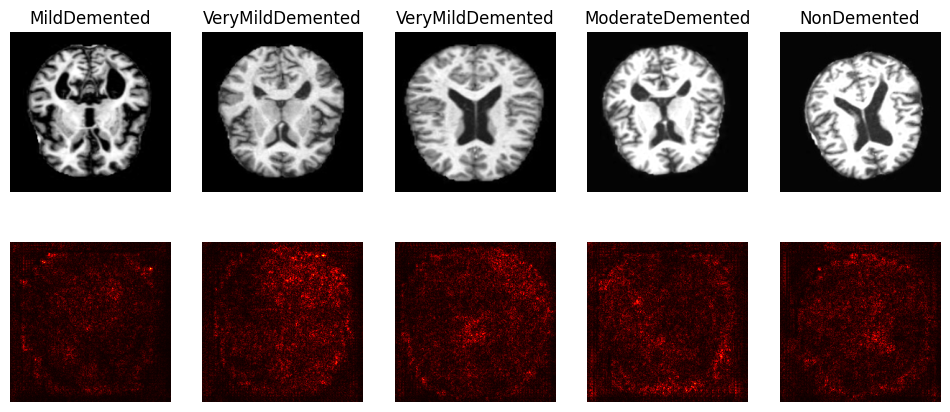

In [13]:
show_saliency()

In [14]:
import torch.nn.functional as F

class GuidedReLU(torch.nn.Module):
    def forward(self, input):
        '''
        Function designed to only allow positive gradients in backprop
        '''
        positive_mask = (input > 0).type_as(input)
        output = F.relu(input)
        return output * positive_mask

def replace_relu_with_guidedrelu(model):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.ReLU):
            setattr(model, name, GuidedReLU())
        else:
            replace_relu_with_guidedrelu(module)

In [15]:
def guided_backprop(model, images, target_class):
    replace_relu_with_guidedrelu(model)

    model.eval()

    images.requires_grad_()
    outputs = model(images)

    model.zero_grad()

    one_hot_output = torch.zeros_like(outputs)
    one_hot_output[:, target_class] = 1

    outputs.backward(gradient=one_hot_output)

    saliency = images.grad.abs()
    return saliency

In [16]:
import numpy as np

def overlay_saliency_map(original_image, saliency_map, alpha=0.5):
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

    cmap = plt.get_cmap('hot')

    saliency_colored = cmap(saliency_map)

    # Overlay the saliency map on the original image
    plt.imshow(original_image, cmap='gray')
    plt.imshow(saliency_colored, alpha=alpha)  # alpha controls the transparency
    plt.axis('off')
    plt.show()

In [17]:
images, _ = next(iter(train_loader))  # Get a batch of images
target_class = 1  # Class you want to visualize
saliency = guided_backprop(model, images, target_class)

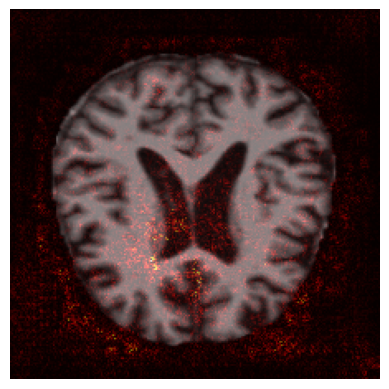

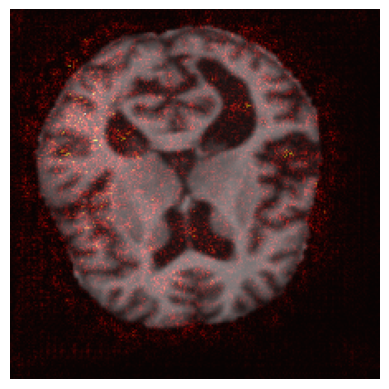

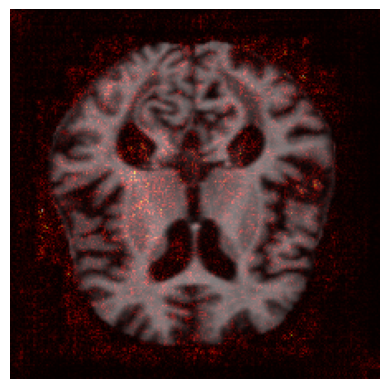

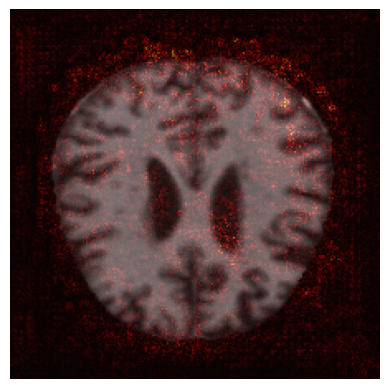

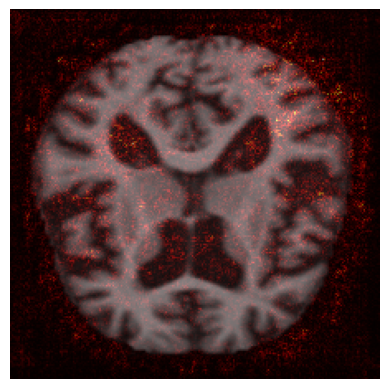

In [18]:
num_images = 5

for i in range(num_images):
    original_image = images[i].detach().numpy()[0]
    saliency_map = saliency[i].squeeze().detach().numpy()[0]
    overlay_saliency_map(original_image, saliency_map)

plt.show()